In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed


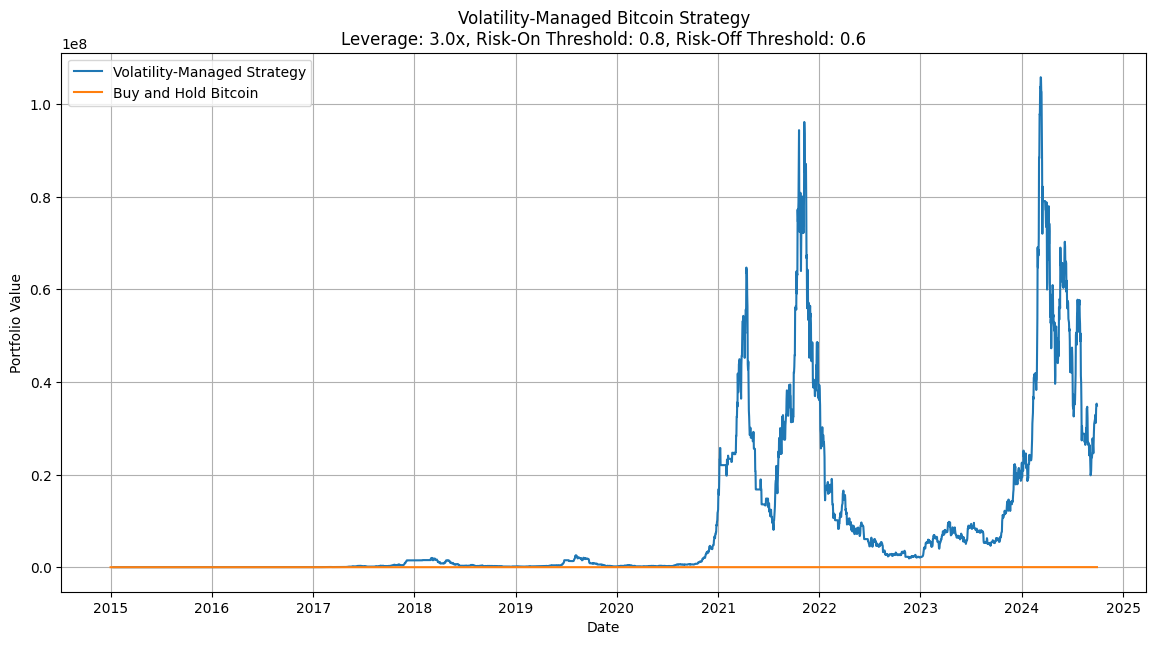

In [2]:
def calculate_bitcoin_volatility_managed_strategy(
    start_date, end_date, lookback_period=20, risk_on_threshold=0.8,
    risk_off_threshold=1.2, initial_value=100.0, leverage=3.0
):
    """
    Calculates the performance of a volatility-managed Bitcoin strategy.

    Parameters:
    - start_date: Start date for fetching data (e.g., '2015-01-01').
    - end_date: End date for fetching data (e.g., '2023-12-31').
    - lookback_period: Number of days to calculate rolling volatility.
    - risk_on_threshold: Volatility threshold to switch from stablecoins to leveraged Bitcoin.
    - risk_off_threshold: Volatility threshold to switch from leveraged Bitcoin back to stablecoins.
    - initial_value: Initial investment value.
    - leverage: The leverage factor for the leveraged Bitcoin position.

    Returns:
    - strategy_df: DataFrame containing strategy value and allocation over time.
    - btc_data: DataFrame containing Bitcoin data and calculated metrics.
    """
    # Fetch historical Bitcoin data
    btc_data = yf.download('BTC-USD', start=start_date, end=end_date)

    # Ensure the data is continuous
    btc_data = btc_data.asfreq('D').ffill()

    # Calculate daily returns
    btc_data['BTC Returns'] = btc_data['Adj Close'].pct_change()

    # Simulate leveraged Bitcoin returns
    btc_data['Leveraged BTC Returns'] = btc_data['BTC Returns'] * leverage

    # Calculate rolling volatility (annualized)
    btc_data['BTC Volatility'] = btc_data['BTC Returns'].rolling(window=lookback_period).std() * np.sqrt(252)

    # Initialize strategy DataFrame
    strategy_df = pd.DataFrame(index=btc_data.index)
    strategy_df['Strategy Value'] = initial_value
    strategy_df['Position'] = 'Stablecoin'  # Start in stablecoin
    strategy_df['Daily Returns'] = 0.0

    # Initial position
    position = 'Stablecoin'

    # Loop starting from lookback_period to ensure volatility is available
    for i in range(lookback_period, len(strategy_df)):
        current_volatility = btc_data.iloc[i]['BTC Volatility']
        previous_position = position

        # Strategy logic with risk_on and risk_off thresholds
        if pd.isna(current_volatility):
            # Stay in the previous position if volatility is NaN
            position = previous_position
        else:
            if position == 'Stablecoin' and current_volatility <= risk_on_threshold:
                position = 'Leveraged BTC'
            elif position == 'Leveraged BTC' and current_volatility >= risk_off_threshold:
                position = 'Stablecoin'

        # Update position
        strategy_df.iloc[i, strategy_df.columns.get_loc('Position')] = position

        # Update strategy value based on position
        if position == 'Leveraged BTC':
            daily_return = btc_data.iloc[i]['Leveraged BTC Returns']
        else:
            daily_return = 0  # Stablecoin assumed to have zero return

        # Apply transaction costs if position changes
        if position != previous_position:
            transaction_cost = strategy_df.iloc[i-1]['Strategy Value'] * 0.001  # Assuming 0.1% transaction cost
            strategy_value = (strategy_df.iloc[i-1]['Strategy Value'] - transaction_cost) * (1 + daily_return)
        else:
            strategy_value = strategy_df.iloc[i-1]['Strategy Value'] * (1 + daily_return)

        # Update strategy value and returns
        strategy_df.iloc[i, strategy_df.columns.get_loc('Strategy Value')] = strategy_value
        strategy_df.iloc[i, strategy_df.columns.get_loc('Daily Returns')] = strategy_value / strategy_df.iloc[i-1]['Strategy Value'] - 1

    # Remove initial NaN values (up to lookback_period)
    strategy_df = strategy_df.iloc[lookback_period:]

    return strategy_df, btc_data


# Define parameters
start_date = '2015-01-01'
end_date = '2024-09-30'
lookback_period = 10
risk_on_threshold = 0.8   # Volatility threshold to enter leveraged Bitcoin
risk_off_threshold = 0.6  # Volatility threshold to exit leveraged Bitcoin
initial_value = 100.0
leverage = 3.0  # Set your desired leverage

# Run the strategy
strategy_df, btc_data = calculate_bitcoin_volatility_managed_strategy(
    start_date, end_date, lookback_period, risk_on_threshold, risk_off_threshold,
    initial_value, leverage
)

# Plot the strategy performance
plt.figure(figsize=(14, 7))
plt.plot(strategy_df.index, strategy_df['Strategy Value'], label='Volatility-Managed Strategy')

# Calculate buy and hold Bitcoin performance
btc_data['Cumulative Returns'] = (1 + btc_data['BTC Returns'].fillna(0)).cumprod()
plt.plot(btc_data.index, initial_value * btc_data['Cumulative Returns'], label='Buy and Hold Bitcoin')

plt.title(f'Volatility-Managed Bitcoin Strategy\nLeverage: {leverage}x, Risk-On Threshold: {risk_on_threshold}, Risk-Off Threshold: {risk_off_threshold}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
def calculate_performance_metrics(strategy_returns):
    """
    Calculates performance metrics for the strategy.

    Parameters:
    - strategy_returns: Series of daily returns.

    Returns:
    - metrics: Dictionary containing performance metrics.
    """
    metrics = {}
    
    # Remove any NaN values
    strategy_returns = strategy_returns.dropna()
    
    # Calculate total number of trading days
    trading_days = len(strategy_returns)
    if trading_days == 0:
        print("No trading data available to calculate metrics.")
        return metrics
    
    # Annualized Return
    cumulative_return = (1 + strategy_returns).prod() - 1
    total_years = trading_days / 252  # Assuming 252 trading days per year
    if total_years > 0:
        annualized_return = (1 + cumulative_return) ** (1 / total_years) - 1
    else:
        annualized_return = 0.0

    # Annualized Volatility
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming risk-free rate is zero
    if annualized_volatility != 0:
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    else:
        sharpe_ratio = np.nan
    
    # Maximum Drawdown
    cumulative_returns = (1 + strategy_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Downside Deviation
    target_return = 0.0  # Assuming zero as the target (risk-free rate)
    downside_returns = strategy_returns[strategy_returns < target_return]
    if len(downside_returns) > 0:
        downside_deviation = downside_returns.std() * np.sqrt(252)
    else:
        downside_deviation = 0.0

    # Sortino Ratio
    if downside_deviation != 0:
        sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation
    else:
        sortino_ratio = np.nan

    # Store the metrics
    metrics['Annualized Return'] = annualized_return
    metrics['Annualized Volatility'] = annualized_volatility
    metrics['Sharpe Ratio'] = sharpe_ratio
    metrics['Max Drawdown'] = max_drawdown
    metrics['Downside Deviation'] = downside_deviation
    metrics['Sortino Ratio'] = sortino_ratio

    return metrics


# Calculate metrics for the strategy
metrics = calculate_performance_metrics(strategy_df['Daily Returns'])
print("Performance Metrics for Volatility-Managed Bitcoin Strategy:")
for key, value in metrics.items():
    print(f"{key}: {value:.2%}")


Performance Metrics for Volatility-Managed Bitcoin Strategy:
Annualized Return: 147.45%
Annualized Volatility: 107.96%
Sharpe Ratio: 136.58%
Max Drawdown: -98.03%
Downside Deviation: 80.16%
Sortino Ratio: 183.95%


In [4]:
# Example of testing different thresholds
thresholds = [
    {'risk_on': 0.7, 'risk_off': 1.0},
    {'risk_on': 0.8, 'risk_off': 1.2},
    {'risk_on': 0.9, 'risk_off': 1.5},
]

for th in thresholds:
    strategy_df, btc_data = calculate_bitcoin_volatility_managed_strategy(
        start_date, end_date, lookback_period, th['risk_on'], th['risk_off'],
        initial_value, leverage
    )
    metrics = calculate_performance_metrics(strategy_df['Daily Returns'])
    print(f"\nRisk-On Threshold: {th['risk_on']}, Risk-Off Threshold: {th['risk_off']}")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Risk-On Threshold: 0.7, Risk-Off Threshold: 1.0
Annualized Return: 59.24%
Annualized Volatility: 144.22%
Sharpe Ratio: 41.08%
Max Drawdown: -99.93%
Downside Deviation: 110.23%
Sortino Ratio: 53.75%



[*********************100%%**********************]  1 of 1 completed


Risk-On Threshold: 0.8, Risk-Off Threshold: 1.2
Annualized Return: 33.60%
Annualized Volatility: 154.65%
Sharpe Ratio: 21.73%
Max Drawdown: -99.91%
Downside Deviation: 118.87%
Sortino Ratio: 28.27%



Risk-On Threshold: 0.9, Risk-Off Threshold: 1.5
Annualized Return: 21.31%
Annualized Volatility: 163.09%
Sharpe Ratio: 13.07%
Max Drawdown: -99.89%
Downside Deviation: 123.74%
Sortino Ratio: 17.22%


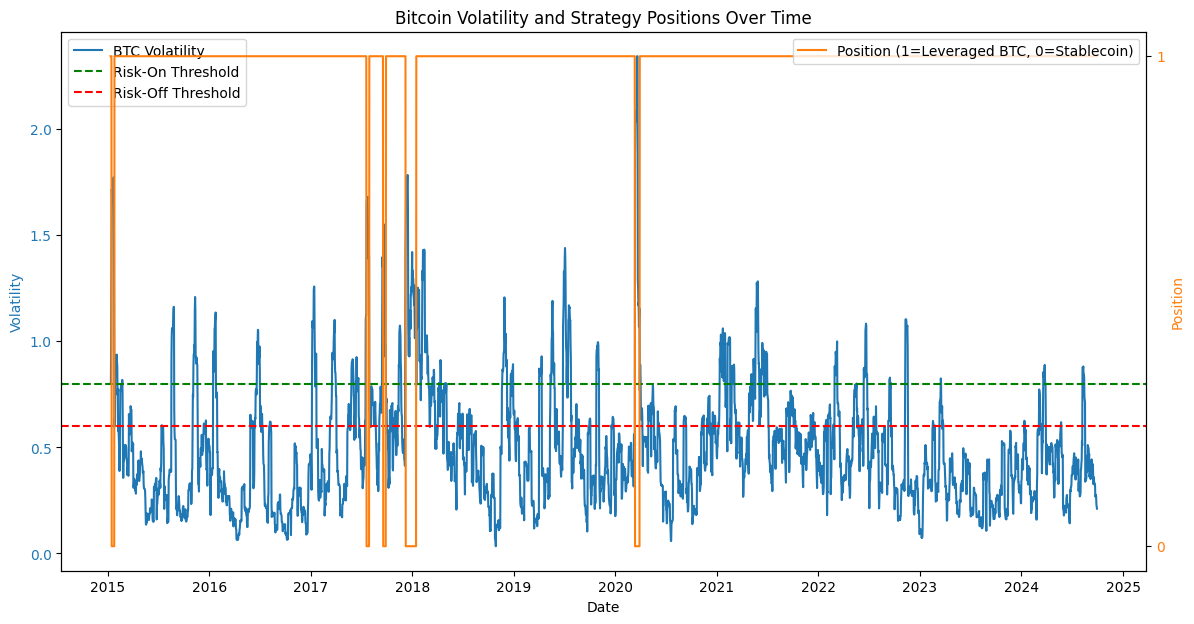

In [5]:
# Plot volatility and positions
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color=color)
ax1.plot(btc_data.index, btc_data['BTC Volatility'], color=color, label='BTC Volatility')
ax1.axhline(y=risk_on_threshold, color='green', linestyle='--', label='Risk-On Threshold')
ax1.axhline(y=risk_off_threshold, color='red', linestyle='--', label='Risk-Off Threshold')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Position', color=color)
ax2.plot(strategy_df.index, (strategy_df['Position'] == 'Leveraged BTC').astype(int), color=color, label='Position (1=Leveraged BTC, 0=Stablecoin)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1])
ax2.legend(loc='upper right')

plt.title('Bitcoin Volatility and Strategy Positions Over Time')
plt.show()


In [6]:
# Strategy performance metrics
strategy_metrics = calculate_performance_metrics(strategy_df['Daily Returns'])

# Buy-and-hold performance metrics
buy_and_hold_returns = btc_data['BTC Returns'].fillna(0)
buy_and_hold_metrics = calculate_performance_metrics(buy_and_hold_returns)

# Display metrics
print("Volatility-Managed Strategy Metrics:")
for key, value in strategy_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2%}")
    else:
        print(f"{key}: {value}")

print("\nBuy-and-Hold Bitcoin Metrics:")
for key, value in buy_and_hold_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2%}")
    else:
        print(f"{key}: {value}")


Volatility-Managed Strategy Metrics:
Annualized Return: 21.31%
Annualized Volatility: 163.09%
Sharpe Ratio: 13.07%
Max Drawdown: -99.89%
Downside Deviation: 123.74%
Sortino Ratio: 17.22%

Buy-and-Hold Bitcoin Metrics:
Annualized Return: 45.95%
Annualized Volatility: 57.94%
Sharpe Ratio: 79.32%
Max Drawdown: -83.40%
Downside Deviation: 44.13%
Sortino Ratio: 104.14%
